# African Antelope Classification using FastAI

Interactive notebook with an end-to-end case study of creating a custom image dataset of major African antelope and training a deep convolutional neural network to classify each species.

An in depth discussion of the case study is available at: https://www.avanwyk.com/african-antelope-fastai-image-classifier

The basic workflow is as follows:
1. Download images of each antelope and build a dataset.
2. Pre-process and prepare the dataset for learning.
3. Create a deep neural network model for classification.
4. Train the DNN using transfer learning on the data.
5. Validate and evaluate the model.

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.vision import *
from fastai.metrics import error_rate, accuracy

In [49]:
from antelope_classification import *

In [4]:
import logging
logging.getLogger('matplotlib').setLevel(logging.WARNING)
logging.getLogger('PIL').setLevel(logging.WARNING)

In [5]:
antelopes = ANTELOPE; print(antelopes)

['kudu', 'eland', 'sable antelope', 'roan antelope', 'waterbuck', 'impala antelope', 'nyala', 'bushbuck', 'tsessebe', 'lichtensteins hartebeest', 'grey duiker', 'steenbok', 'klipspringer']


## Download image data

Here we download images to the data directory; each species is added to its own directory. We also check whether the image file names indicate any potential mislabeling.

In [6]:
download_antelope_images(DATA_PATH)

INFO:root:Directory 'data' is not empty. Skipping image download.


In [7]:
validate_labels(DATA_PATH, ANTELOPE)

INFO:root:Potential mislabeling: data/kudu/nyalakudujpg
INFO:root:Potential mislabeling: data/kudu/nyalakudujpg
INFO:root:Potential mislabeling: data/nyala/differencebetweenkuduandnyalajpg


*100* examples (50 male/50 femail) of each class is downloaded, for a total dataset size of 1300 images. This was manually cleaned leaving roughly 1100 images.

The label validation shows a few potential mislabels, all of which are from species comparison images, and are in fact labeled correctly.

Further manual inspection of the data should be done to ensure there are no other examples that are mislabeled or inappriopate for the task at hand.

## Build and visualize datasets

With the data downloaded, we can construct an [ImageDataBunch](https://docs.fast.ai/vision.data.html#ImageDataBunch) with appropriate transforms. The image data is normalized with the imagenet statistics.

In [8]:
DATA_PATH = Path('data')
VALID_PCT = 0.2
IMAGE_SIZE = 224
BATCH_SIZE = 32

In [9]:
image_data = ImageDataBunch.from_folder(DATA_PATH, valid_pct=VALID_PCT,\
                                            ds_tfms=get_transforms(), size=IMAGE_SIZE,
                                            bs=BATCH_SIZE).normalize(imagenet_stats)

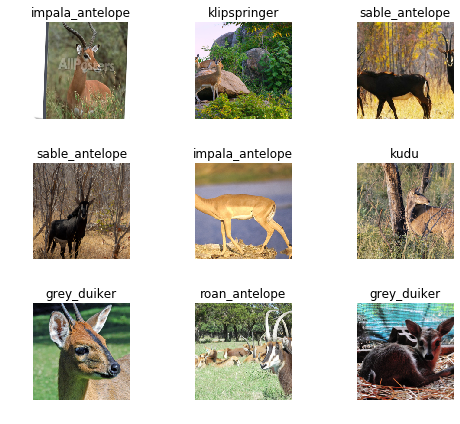

In [10]:
image_data.show_batch(3, figsize=(7,6))

In [11]:
print(image_data.classes)
len(image_data.classes) == image_data.c == len(ANTELOPE)

['bushbuck', 'eland', 'grey_duiker', 'impala_antelope', 'klipspringer', 'kudu', 'lichtensteins_hartebeest', 'nyala', 'roan_antelope', 'sable_antelope', 'steenbok', 'tsessebe', 'waterbuck']


True

We visualize a batch of data to get an idea of what will be passed to the CNN. We also validate that the ImageDataBunch correctly picked all of our classes, which it did.

## Create Pre-trained Model

In [13]:
ARCHITECTURE = models.resnet34

We now create a CNN model pre-trained on the Imagenet dataset.

In [14]:
learn = cnn_learner(image_data, ARCHITECTURE, metrics=[error_rate, accuracy])

In [15]:
learn.model

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (rel

We use a standard Resnet50 architecture for training, pre-trained on the ImageNet dataset.

## Train Model (top layer)

In the first stage of training, we only fine-tune (fit) the top (fully-connected) layers of the ResNet. We must also first find an appropriate learning rate to use.

In [16]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


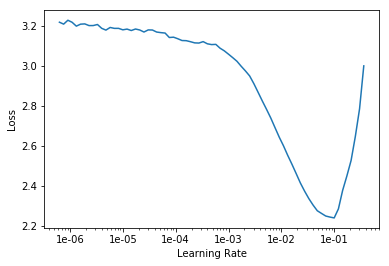

In [17]:
learn.recorder.plot()

In [18]:
learn.fit_one_cycle(4, max_lr=slice(1e-3, 1e-2))

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,1.836340,0.820739,0.240175,0.759825,00:07
1,1.134924,0.597667,0.200873,0.799127,00:07
2,0.834604,0.550626,0.174672,0.825328,00:07
3,0.623809,0.509779,0.144105,0.855895,00:07


In [19]:
learn.save('stage-1')

We train the network for 5 epochs using the learning rate range we found using `lr_find`. The network achieves and accuracy of about 85% after the initial training.

### Results and Interpretation

With the model trained we can investigate where the model is struggling and validate its accuracy.

In [20]:
from sklearn.metrics import f1_score

In [21]:
interp = ClassificationInterpretation.from_learner(learn)

In [22]:
losses, idxs = interp.top_losses()

In [23]:
len(image_data.valid_ds) == len(losses)

True

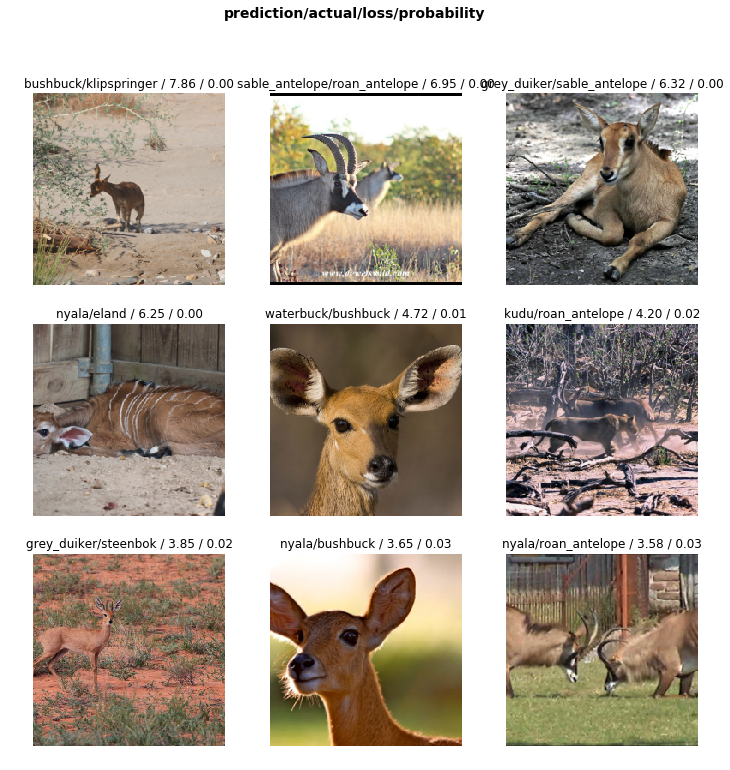

In [24]:
interp.plot_top_losses(9, heatmap=False)

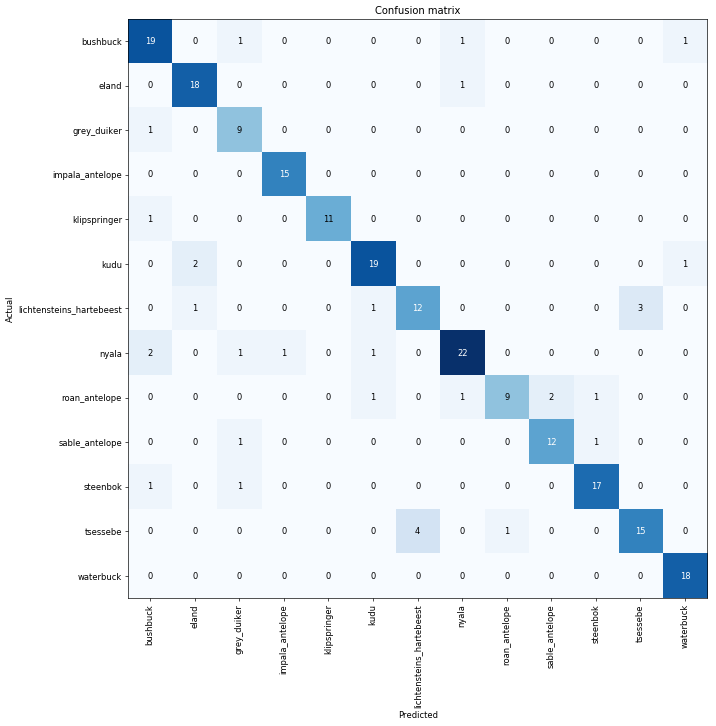

In [25]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [26]:
interp.most_confused(min_val=2)

[('tsessebe', 'lichtensteins_hartebeest', 4),
 ('lichtensteins_hartebeest', 'tsessebe', 3),
 ('kudu', 'eland', 2),
 ('nyala', 'bushbuck', 2),
 ('roan_antelope', 'sable_antelope', 2)]

In [27]:
preds, targets = learn.TTA()
predicted_classes = np.argmax(preds, axis=1)

f1_score(targets, predicted_classes, average='micro')

0.8864628820960698

We achieve and F1 score of 0.8821, with the network seeming to struggle with images of front and rear views of the antelope, images of of a close-up of the antelope's face and images of young antelope.

## Enhancing the Data

We can download additional images of the examples the model is struggling with. Additionally we can clean the data using the pre-trained model.

### Additional Data

We download additional data, specfying a 'front' view of the antelope.

In [51]:
download_antelope_images(Path('add_data'), limit=10, kws=['"front"'])

INFO:root:Directory 'add_data does not exist and will be created.



Item no.: 1 --> Item name = wild kudu male "front" -hunting -stock
Evaluating...
Starting Download...
Completed Image ====> 1. 785fec3ff4d0fffa01d1a26298a7ba48.jpg
Completed Image ====> 2. img_8690-1-1024x683.jpg
Completed Image ====> 3. 67995e0270e91a53875269e78341913b.jpg
Completed Image ====> 4. 2.jpg
Completed Image ====> 5. kudu_bull.jpg
Completed Image ====> 6. 400_f_220289491_ww83dgo8pqlvxcnsxayrd7a9khnk9eow.jpg
Completed Image ====> 7. kudu.jpg
Completed Image ====> 8. cbbe9e52459554cd09fc3838c0e4963e--game-lodge-south-africa.jpg
Completed Image ====> 9. e0225e7532ff374cd0f70c324a50e150.jpg
Completed Image ====> 10. 0.jpg

Errors: 0


Item no.: 1 --> Item name = wild kudu female "front" -hunting -stock
Evaluating...
Starting Download...
Completed Image ====> 1. 785fec3ff4d0fffa01d1a26298a7ba48.jpg
Completed Image ====> 2. img_8690-1-1024x683.jpg
Completed Image ====> 3. kudu.jpg
Completed Image ====> 4. kudu_bull.jpg
Completed Image ====> 5. kudu-female-and-calf-botswana.jpg
C

Starting Download...
Completed Image ====> 1. orchestrated-nyala_2012_09_04_6156_768x474px.jpg
Completed Image ====> 2. image104.jpg
Completed Image ====> 3. 2b88d505cc99f3c3f759fd6534928119.jpg
Completed Image ====> 4. 6a010535647bf3970b022ad39f6c8c200d-800wi.jpg
Completed Image ====> 5. 0.jpg
Completed Image ====> 6. 6a010535647bf3970b022ad3bf0a78200b-800wi.jpg
Completed Image ====> 7. 6a010535647bf3970b022ad3bf0aa1200b-800wi.jpg
Completed Image ====> 8. 0.jpg
Completed Image ====> 9. 6a010535647bf3970b022ad39f6cb2200d-800wi.jpg
Completed Image ====> 10. nyala-male-chisomo.jpg

Errors: 0


Item no.: 1 --> Item name = wild nyala female "front" -hunting -stock
Evaluating...
Starting Download...
Completed Image ====> 1. 1024px-nyala_%28female%29%2c_mlilwane_wildlife_sanctuary.jpg
Completed Image ====> 2. 2b88d505cc99f3c3f759fd6534928119.jpg
Completed Image ====> 3. 6a010535647bf3970b022ad39f6c8c200d-800wi.jpg
Completed Image ====> 4. orchestrated-nyala_2012_09_04_6156_768x474px.jpg
Comp

Completed Image ====> 2. 02louise-murray-klipspringer-06082018-1-final-935x667.jpg
Completed Image ====> 3. klipspringer_560x437.jpg.asp
Completed Image ====> 4. 0.jpg
Completed Image ====> 5. klipspringer-on-rocks.jpg
Completed Image ====> 6. flat,800x800,075,f.u7.jpg
Completed Image ====> 7. img_0044.jpg
Completed Image ====> 8. klipspringer-264a85t-1024x682.jpg
Completed Image ====> 9. klipspringer-botswana.jpg
Completed Image ====> 10. 51745167_415860122555074_8147214393177439798_n.jpg

Errors: 0


Item no.: 1 --> Item name = wild klipspringer female "front" -hunting -stock
Evaluating...
Starting Download...
Completed Image ====> 1. marli-potgieter-kruger-klipspringer-4-min-1140x660.jpg
Completed Image ====> 2. 02louise-murray-klipspringer-06082018-1-final-935x667.jpg
Completed Image ====> 3. flat,800x800,075,f.u7.jpg
Completed Image ====> 4. klipspringer_560x437.jpg.asp
Completed Image ====> 5. 0.jpg
Completed Image ====> 6. img_0044.jpg
Completed Image ====> 7. klipspringer-on-ro

### Revisition Augmentation Transforms

Next we modify our data transforms slightly to better suit our use case.

In [130]:
xtra_tfms = [RandTransform(tfm=TfmAffine(zoom), kwargs={'scale': (0.7, 1.0)}, p=0.85)]
transforms = get_transforms(max_rotate=5, p_affine=0.85, p_lighting=0.5, xtra_tfms=xtra_tfms)

## Model Assisted Data Cleaning

We need to re-train the model on the new dataset that includes the additional images we downloaded and the new updated image transforms. Then we can use the model itself to clean the dataset (by looking at images which has the highest loss values) and using the FastAI [ImageCleaner](https://docs.fast.ai/widgets.image_cleaner.html) widget.

In [73]:
image_data = ImageDataBunch.from_folder(DATA_PATH, valid_pct=VALID_PCT,\
                                            ds_tfms=transforms, size=IMAGE_SIZE,
                                            bs=BATCH_SIZE).normalize(imagenet_stats)

In [74]:
learn = cnn_learner(image_data, ARCHITECTURE, metrics=[error_rate, accuracy])
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


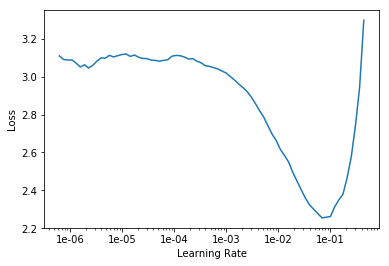

In [76]:
learn.recorder.plot()

In [77]:
learn.fit_one_cycle(4, max_lr=slice(3e-3, 1e-2))

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,1.743002,0.672977,0.235741,0.764259,00:08
1,1.116160,0.662975,0.186312,0.813688,00:08
2,0.794356,0.506970,0.148289,0.851711,00:08
3,0.569565,0.468571,0.140684,0.859316,00:08


In [78]:
from fastai.widgets import *

In [79]:
images = (ImageList.from_folder(DATA_PATH)
                   .split_none()
                   .label_from_folder()
                   .transform(transforms, size=224)
                   .databunch())

In [81]:
ds, idxs = DatasetFormatter().from_toplosses(learn)

In [83]:
ImageCleaner(ds, idxs, DATA_PATH)

Button(button_style='primary', description='Next Batch', layout=Layout(width='auto'), style=ButtonStyle())

## Full Model Training

In [86]:
np.random.seed(84)
df = pd.read_csv(DATA_PATH/'cleaned.csv', header='infer')

In [ ]:
xtra_tfms = [RandTransform(tfm=TfmAffine(zoom), kwargs={'scale': (0.7, 1.0)}, p=0.85)]
transforms = get_transforms(max_rotate=5, p_affine=0.85, p_lighting=0.5, xtra_tfms=xtra_tfms)

In [104]:
df = pd.read_csv(DATA_PATH/'cleaned.csv', header='infer')
image_data = ImageDataBunch.from_df(DATA_PATH, df, valid_pct=VALID_PCT,\
                                            ds_tfms=transforms, size=IMAGE_SIZE,
                                            bs=BATCH_SIZE).normalize(imagenet_stats)

In [110]:
learn = cnn_learner(image_data, ARCHITECTURE, metrics=[error_rate, accuracy])

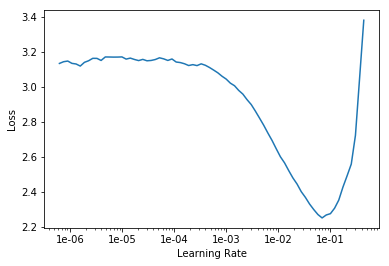

In [106]:
learn.lr_find()
learn.recorder.plot()

In [111]:
learn.fit_one_cycle(4, max_lr=slice(1e-3, 1e-2))

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,1.925807,0.792753,0.277228,0.722772,00:07
1,1.175823,0.634750,0.217822,0.782178,00:07
2,0.787624,0.598048,0.193069,0.806931,00:07
3,0.573623,0.574786,0.178218,0.821782,00:07


To improve the network's performance, we can proceed with unfreezing the model, allowing us to train all the layers of the ResNet (instead of just fine tuning the final layers as with stage-1).

In [112]:
learn.unfreeze()

In [113]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


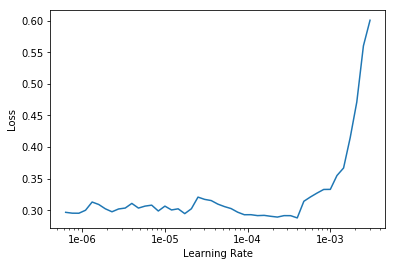

In [114]:
learn.recorder.plot()

In [127]:
learn.fit_one_cycle(5, max_lr=1e-4)

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.033978,0.946565,0.123762,0.876238,00:08
1,0.030352,0.943647,0.108911,0.891089,00:08
2,0.043319,1.045896,0.173267,0.826733,00:08


Traceback (most recent call last):
  File "/home/avanwyk/Tools/anaconda/envs/fai-course-env/lib/python3.7/multiprocessing/queues.py", line 242, in _feed
    send_bytes(obj)
  File "/home/avanwyk/Tools/anaconda/envs/fai-course-env/lib/python3.7/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/home/avanwyk/Tools/anaconda/envs/fai-course-env/lib/python3.7/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/home/avanwyk/Tools/anaconda/envs/fai-course-env/lib/python3.7/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe


KeyboardInterrupt: 

In [119]:
learn.fit_one_cycle(20, max_lr=1e-4)

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.040728,0.322874,0.108911,0.891089,00:08
1,0.044839,0.295589,0.103960,0.896040,00:08
2,0.045758,0.364775,0.103960,0.896040,00:08
3,0.059580,0.365244,0.118812,0.881188,00:08
4,0.081818,0.402429,0.113861,0.886139,00:08
5,0.081505,0.431372,0.128713,0.871287,00:08
6,0.068699,0.373765,0.108911,0.891089,00:08
7,0.066584,0.348202,0.113861,0.886139,00:08
8,0.049825,0.341181,0.108911,0.891089,00:08
9,0.041122,0.333890,0.113861,0.886139,00:08


In [118]:
learn.save('stage-2-a')

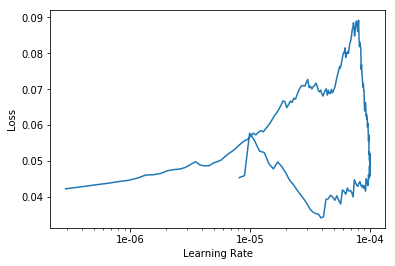

In [120]:
learn.recorder.plot()

The model's validation accuracy improves to 87%. The training loss also greatly improved and is significanlty lower than the validation loss which indicates that the network is overfitting on the training set.

### Results and Interpretation

We again analyze the performance and validate the F1 score.

In [121]:
interp = ClassificationInterpretation.from_learner(learn)

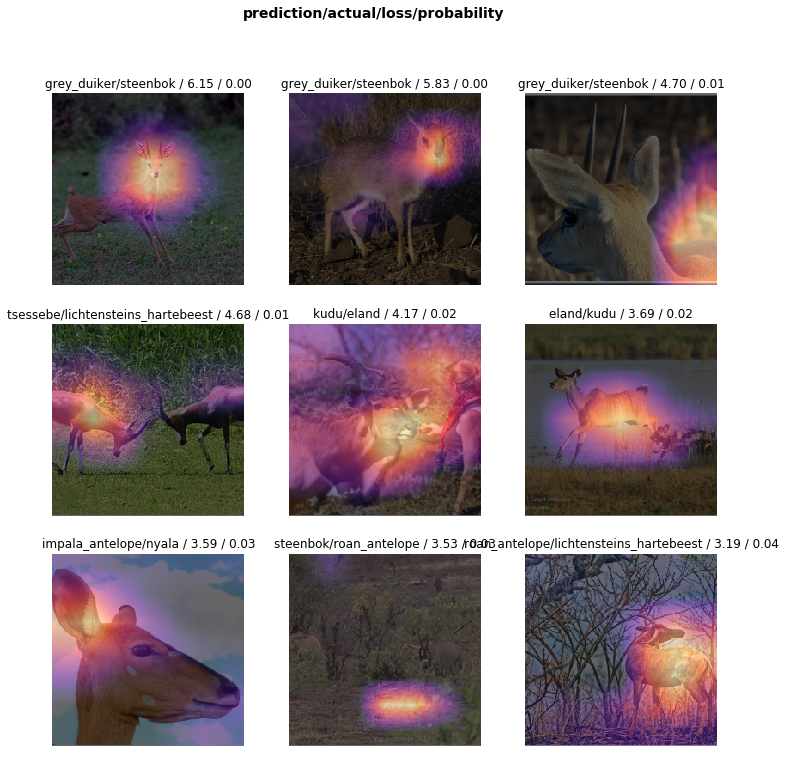

In [122]:
interp.plot_top_losses(9, figsize=(12,12), heatmap=True)

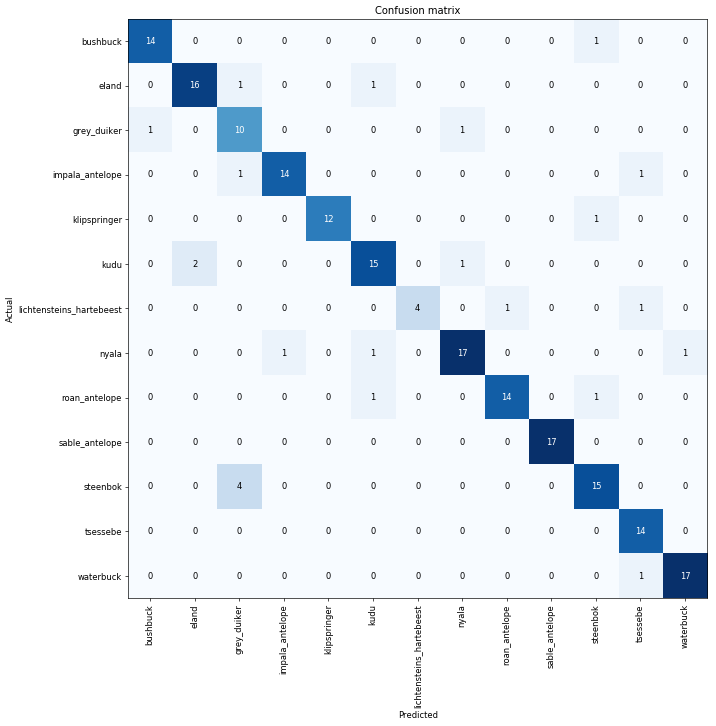

In [123]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [124]:
interp.most_confused(min_val=2)

[('steenbok', 'grey_duiker', 4), ('kudu', 'eland', 2)]

Even though the accuracy itself has not greatly improved, the network is more confident in some of the classes. Encouragingly, it also now seems to be struggling with species that are similar to each other, even to experts, e.g. Tsessebe vs Lichtenstein's Hartebees.

When looking at the examples with the highest loss, we note that in two of the examples the view is from the front of the antelope instead of the typical broadside view. More examples of specifically this case should be added to the dataset.

### Final F1 Score with Test Time Augmentation

In [125]:
preds, targets = learn.TTA()
predicted_classes = np.argmax(preds, axis=1)

f1_score(targets, predicted_classes, average='micro')

0.9158415841584159

## Further Improvement

With only 880 training examples (20% of the dataset was used for validation), ~85 per class, the network achieves a final F1 score of 0.917 with TTA after 10 epochs of training. This is pretty good, but I expect it can be improved upon. Potential areas to investigate are:

- Validate the transformations used to augment the dataset (especially rotation and colour).
- Alternative architectures to avoid overitting. Even a smaller ResNet might be more appropriate.
- Gather more data, especially of examples of specific edge cases (such as the front or rear view).